# Session 5.1 Sigmoid Classification


In [6]:
from matplotlib import pyplot as plt
from typing import Callable, Type
import numpy as np
from IPython import display

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

# Training loop function
from IPython.display import clear_output, display
import time

torch.manual_seed(42)


# Helper functions 

- to visualize
- to focus on stuff that really matters

In [7]:
def viz_1d(X, Y, title = None):
    
    if isinstance(Y, torch.Tensor):
        Y = Y.detach()
        
    plt.figure(figsize=(7, 4))
    if title:
        plt.title(title)
    plt.scatter(X, Y)
    plt.show()
    
def viz_2d(X, Y, title=None):
    plt.figure(figsize=(6,6), dpi=150)
    plt.title("Dataset" if not title else title)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="viridis", s=10)
    plt.show()
  
def viz_all(X, Y, model, f=None, ax=None):
    sns.set(style="white")

    minx, maxx = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    miny, maxy = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    # xx, yy = np.mgrid[minx:maxx:.01, miny:maxy:.01]
    print(minx, maxx, miny, maxy)
    xx, yy = np.mgrid[minx.item():maxx.item():.05, miny.item():maxy.item():.05]
    # xx, yy = np.mgrid[-1.1:1.1:.01, -1.1:1.1:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = model(batch).reshape(xx.shape)
        probs = probs.numpy().reshape(xx.shape)
        
    if (f is None and ax is not None) or (f is not None and ax is None):
        raise ValueError(f"F and AX both should either be None or not")
    
    old_ax = False
    if f is None and ax is None:
        f, ax = plt.subplots(figsize=(16, 10))
        old_ax = True
        
        
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=-0.1, vmax=1.1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[:,0], X[:, 1], c=Y[:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    
    if not old_ax:
        plt.show()

    
def report(model: torch.nn.Module, title='Parameters before update:'):
    op = title[::]
    for np in model.named_parameters():
        op += f"\n\t{np[0]}: {np[1].data.item() if not np[1].shape.__len__()>1 else np[1].data}\tgrad: {np[1].grad if np[1].grad is not None else None}"
    print(op)

In [8]:
# Ze train function
%matplotlib inline
def train(
        model: torch.nn.Module,
          X: torch.Tensor, 
          Y: torch.Tensor,
          loss_function: Callable = torch.nn.MSELoss(), 
          optimizer_class: Type = torch.optim.SGD,
          epochs: int = 200,
          learning_rate: float = 0.01,
          sleep_time: int | None = None,
          early_stopping_threshold: float = 0.002,
          viz_every: int = 1
          ) -> torch.nn.Module:
    
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    losses = []
    
    for epoch in range(epochs+1):

        # Do a train step
        # # Everything else is just 'fluff'
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = loss_function(Y_pred, Y)
        loss.backward()
        optimizer.step()
        
        if epoch % viz_every == 0:
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

            # Scatter your training data
            plt.scatter(X[:,0], X[:,1], c=Y, alpha=0.8)

            # Generate a grid and get predictions (as before)
            x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
            y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                                np.linspace(y_min, y_max, 100))
            grid_points = np.c_[xx.ravel(), yy.ravel()]
            with torch.no_grad():
                logits = model(torch.from_numpy(grid_points).float())
                # Single-logit model => use sigmoid
                probs = torch.sigmoid(logits).numpy().reshape(xx.shape)

            # 1) Show filled contours of probability. 
            contour_f = plt.contourf(xx, yy, probs, levels=20, alpha=0.6)
            plt.colorbar(contour_f, label="Predicted Probability (Class 1)")

            # 2) Optionally plot the 0.5 boundary in black
            plt.contour(xx, yy, probs, levels=[0.5], colors='black')

            plt.title(f"Epoch: {epoch} - Loss: {loss.item()}")
            plt.show()
            # viz_all(X=X, Y=Y, model=model, f=fig, ax=ax)


        # Early stopping
        if loss.item() < early_stopping_threshold:
            print(f"Converged at epoch {epoch}")
            break
        
        if sleep_time is not None:
            time.sleep(sleep_time)

        # Log results
        losses.append(loss.item())

    # Visualize loss
    plt.figure(figsize=(5,3), dpi=200)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (last_avg: {float(np.mean(losses[-len(losses)//10:])):.6f})')
    plt.xticks()
    plt.yticks()
    plt.show()

    return model

# Defining a problem

In [9]:
# Data generation constants
n_samples = 2_000
noise_scale = 0.05

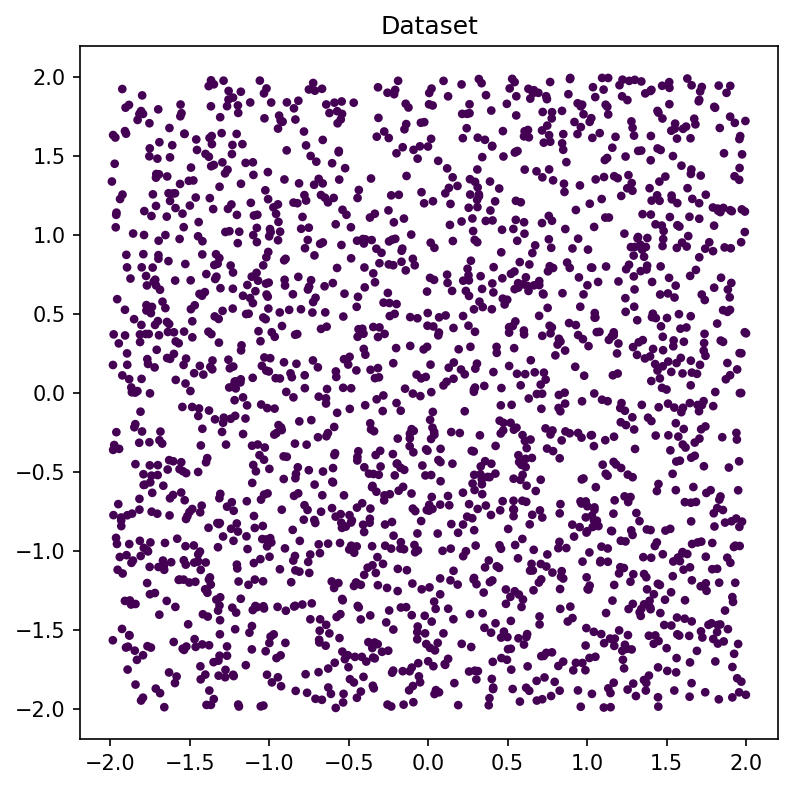

In [11]:
# A circle
radius = 1.0 

def gen_circle(X: torch.Tensor, noise_scale: float) -> torch.Tensor:
    # distance from origin
    distances = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Add some noise to the distances
    distances += torch.randn_like(distances) * noise_scale

    # Label: inside or outside a set radius
    return (distances < radius).float().unsqueeze(1)  # shape: (300, 1)
    

# Generating random x 
X_cir = 4 * (torch.rand(n_samples, 2) - 0.5)  # shape: (n, 2), in [-2,2] square

# Lets try and visualize just the X
viz_2d(X_cir, torch.ones(X_cir.shape[0],1))

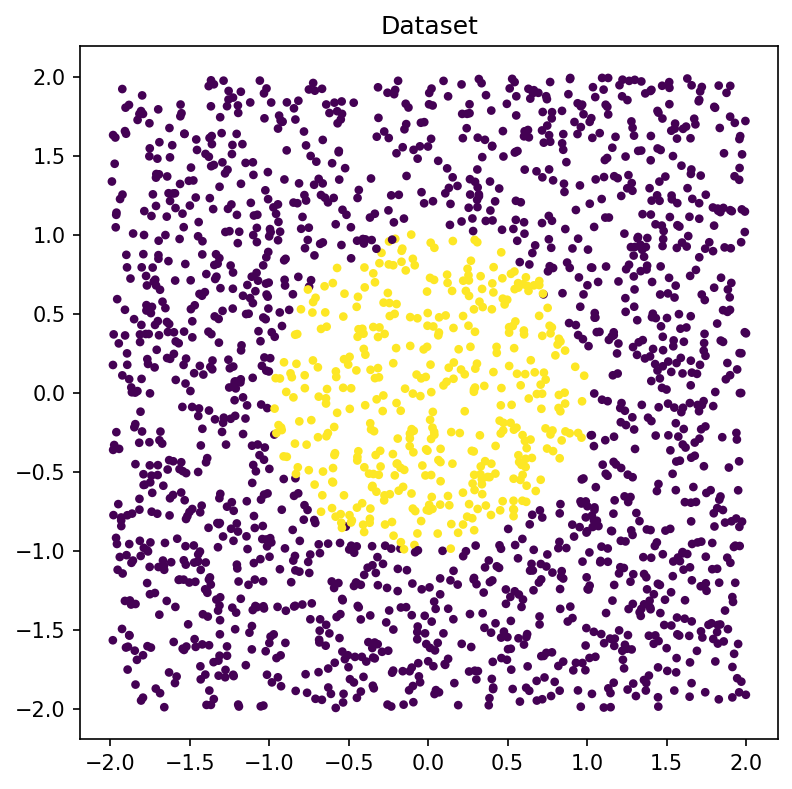

In [12]:
# Lets now generate the labels. For each dot we get either a positive class (1) or a negative class (0)
Y_cir = gen_circle(X_cir, noise_scale*0.5)

viz_2d(X_cir, Y_cir)

In [13]:
# Lets use our MLP as defined in prev session (just varying the input dimension also)
class MLP(torch.nn.Module):
    def __init__(self, input_dim: int = 1, n_hidden_layers: int = 5, act_fn: torch.nn.Module = torch.nn.ReLU, hidden_dim: int = 10):
        #              ^^^^^^^^^^^^^^^^^^
        super().__init__()
        # Define the input layer
        input_layer = torch.nn.Linear(input_dim, hidden_dim)
        #                             ^^^^^^^^^
        
        # Define the hidden layers with activation functions
        hidden_layers = [act_fn()]  # Activation over the input layer
        for _ in range(n_hidden_layers):
            hidden_layers += [torch.nn.Linear(hidden_dim, hidden_dim), act_fn()]
        
        # Define the output layer
        output_layer = torch.nn.Linear(hidden_dim, 1)

        # Combine all layers into a sequential model
        self.layers = torch.nn.Sequential(input_layer, *hidden_layers, output_layer)

    def forward(self, x):
        return self.layers(x)

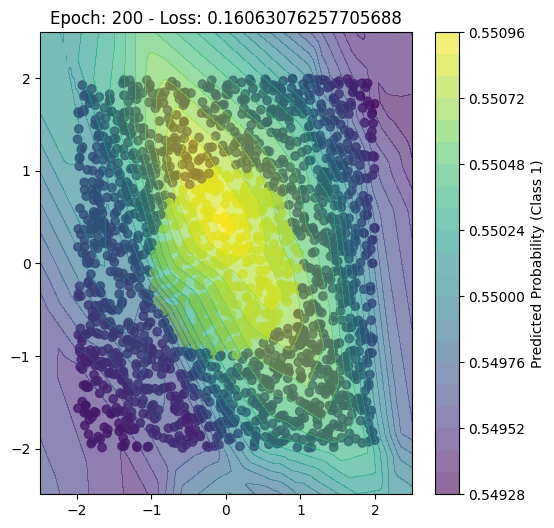

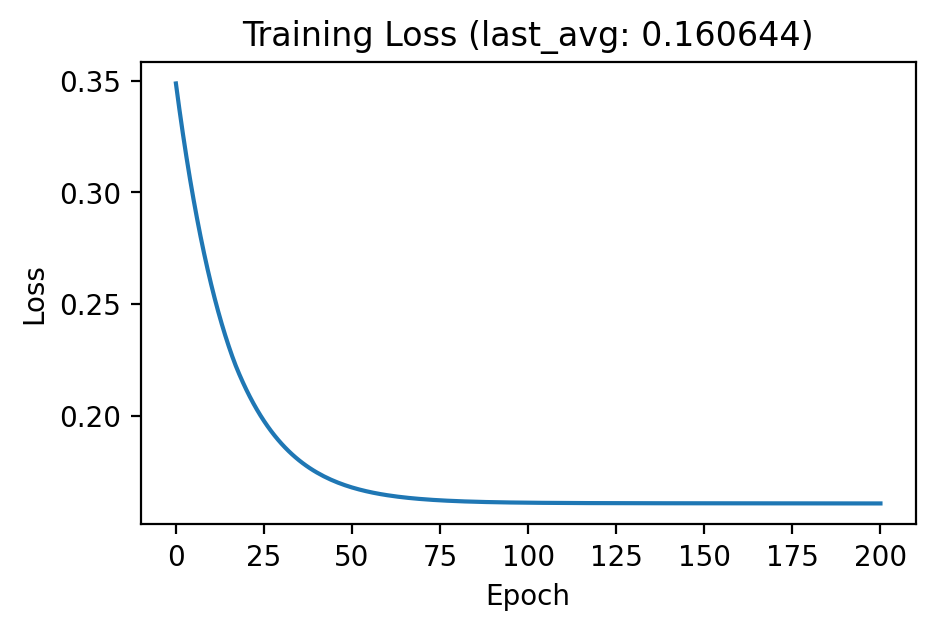

In [14]:
model = train(MLP(2), X_cir, Y_cir, loss_function=torch.nn.MSELoss(), viz_every=10)

In [44]:
# Lets look at what the model actually does
i = 10
_x = X_cir[:i].unsqueeze(0)
_y = Y_cir[:i].unsqueeze(1)

print(_x, _y)
print(_x.shape, _y.shape)

_ypred = MLP(2)(_x)
_ypred

tensor([[[ 1.5291,  1.6600],
         [-0.4685,  1.8372],
         [-0.4382,  0.4036],
         [-0.9737,  1.1746],
         [ 1.7631, -1.4673],
         [ 1.7384,  0.3743],
         [ 1.4776,  0.2709],
         [ 0.9644, -0.2824],
         [ 1.5418,  0.2956],
         [-0.9337,  0.5098]]]) tensor([[[0.]],

        [[0.]],

        [[1.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[1.]],

        [[0.]],

        [[0.]]])
torch.Size([1, 10, 2]) torch.Size([10, 1, 1])


tensor([[[-0.2294],
         [-0.2343],
         [-0.2337],
         [-0.2358],
         [-0.2301],
         [-0.2294],
         [-0.2297],
         [-0.2298],
         [-0.2296],
         [-0.2353]]], grad_fn=<ViewBackward0>)

# But we want an output between 0 and 1

lets treat model output as a probability distribution b/w 0  and 1. Treat the output as a confidence.as_integer_ratio

# But how do we restrict output to this?

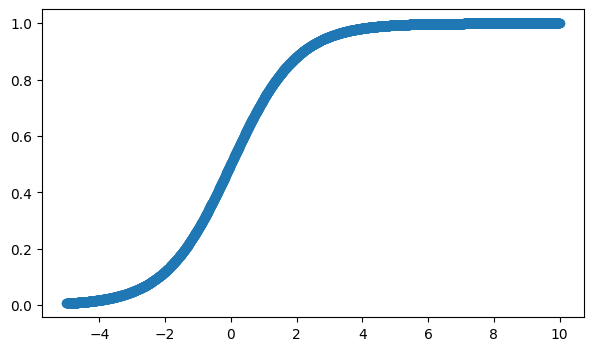

In [45]:
X = torch.linspace(-5, 10, n_samples).unsqueeze(1)
viz_1d(X, torch.sigmoid(X))


In [46]:
# Lets incorporate this into our model?
# Lets use our MLP as defined in prev session (just varying the input dimension also)
class MLPClf(torch.nn.Module):
    def __init__(self, input_dim: int = 1, n_hidden_layers: int = 5, act_fn: torch.nn.Module = torch.nn.ReLU, hidden_dim: int = 10):
        #              ^^^^^^^^^^^^^^^^^^
        super().__init__()
        # Define the input layer
        input_layer = torch.nn.Linear(input_dim, hidden_dim)
        #                             ^^^^^^^^^
        
        # Define the hidden layers with activation functions
        hidden_layers = [act_fn()]  # Activation over the input layer
        for _ in range(n_hidden_layers):
            hidden_layers += [torch.nn.Linear(hidden_dim, hidden_dim), act_fn()]
        
        # Define the output layer
        output_layer = torch.nn.Linear(hidden_dim, 1)

        # Combine all layers into a sequential model
        self.layers = torch.nn.Sequential(input_layer, *hidden_layers, output_layer)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

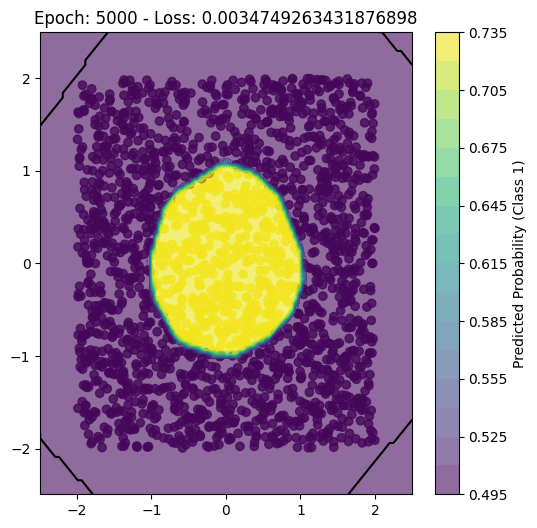

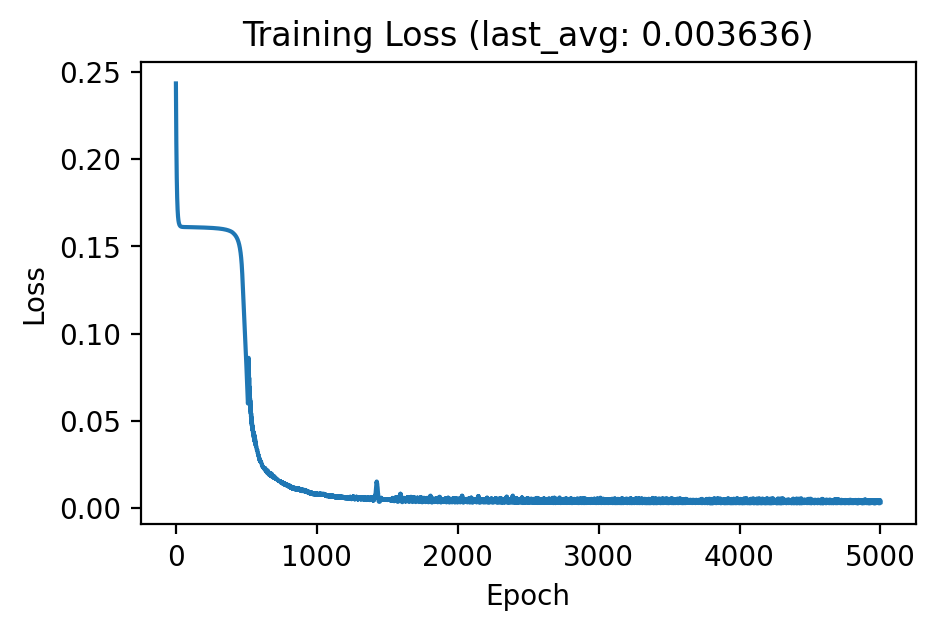

In [56]:
model = train(MLPClf(2), X_cir, Y_cir, viz_every=200, epochs=5000, learning_rate=0.5)

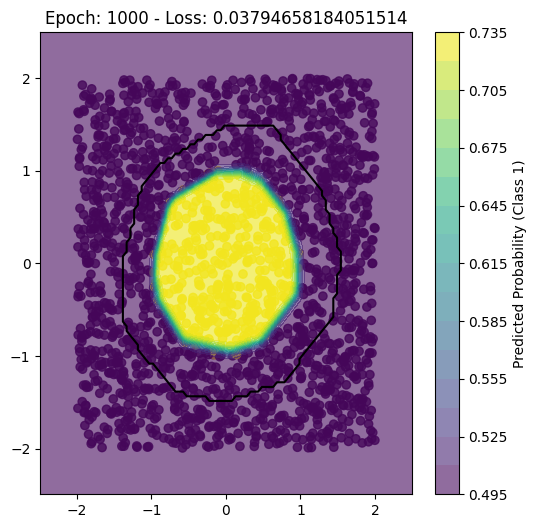

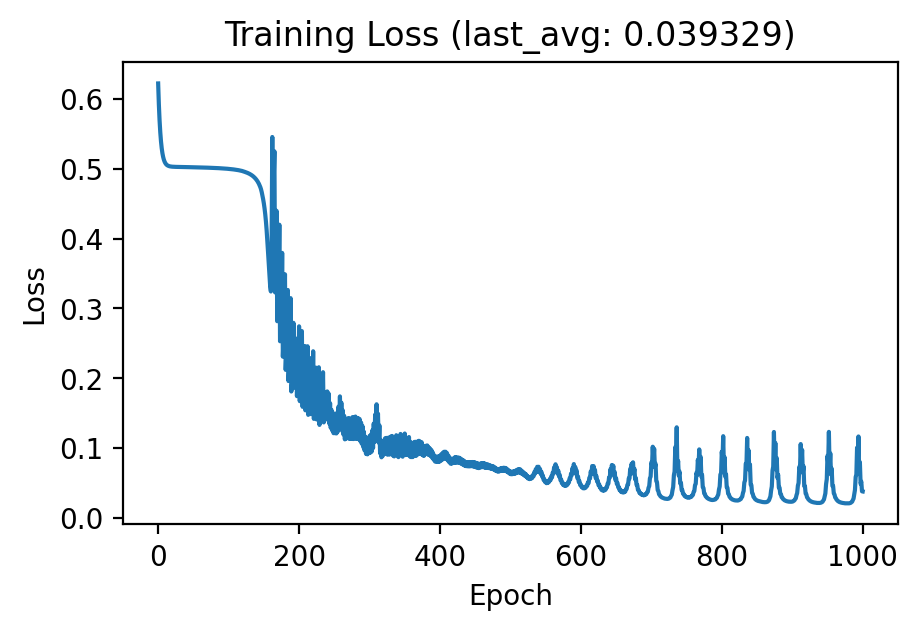

In [59]:
# Its missing one more thing: loss function
model = train(MLPClf(2), X_cir, Y_cir, loss_function=torch.nn.BCELoss(), viz_every=50, epochs=1000, learning_rate=0.5)

# So that's classification

We treat the output as a probability distribution between 0.0 (negative class) and 1.0 (positive class)